In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics

from node2vec import Node2Vec

sns.set_style('whitegrid')

In [2]:
edges_emails = pd.read_csv('../data/emails/edges.txt', sep=' ', header=None, names=['from','to'])
labels_emails = pd.read_csv('../data/emails/node-label.txt', sep=' ', header=None, names=['node', 'label'])

n_clusters = len(labels_emails['label'].unique())

In [3]:
G_emails = nx.Graph()
G_emails.add_nodes_from(edges_emails['from'])
G_emails.add_nodes_from(edges_emails['to'])

In [4]:
for i, row in edges_emails.iterrows():
    G_emails.add_edge(row['from'], row['to'], weight=1)

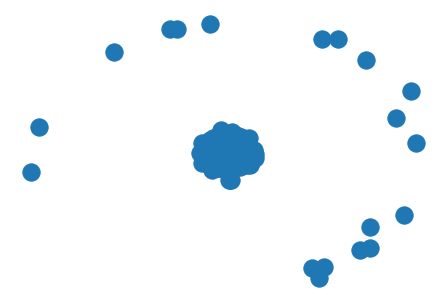

In [6]:
pos = nx.spring_layout(G_emails)
nx.draw(G_emails, cmap = plt.get_cmap('rainbow'), with_labels=False, pos=pos)

In [7]:
node2vec = Node2Vec(G_emails, dimensions=128, walk_length=80, num_walks=10, workers=4)

Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.23it/s]


In [10]:
model = node2vec.fit(window=10, min_count=1)

In [11]:
model.wv.vocab

{'437': <gensim.models.keyedvectors.Vocab at 0x20659b4ef88>,
 '251': <gensim.models.keyedvectors.Vocab at 0x20659b4e388>,
 '169': <gensim.models.keyedvectors.Vocab at 0x20659b4ec48>,
 '409': <gensim.models.keyedvectors.Vocab at 0x20659b660c8>,
 '590': <gensim.models.keyedvectors.Vocab at 0x20659b662c8>,
 '13': <gensim.models.keyedvectors.Vocab at 0x20659b661c8>,
 '191': <gensim.models.keyedvectors.Vocab at 0x20659b66148>,
 '347': <gensim.models.keyedvectors.Vocab at 0x20659b66308>,
 '105': <gensim.models.keyedvectors.Vocab at 0x20659b66188>,
 '285': <gensim.models.keyedvectors.Vocab at 0x20659b66048>,
 '183': <gensim.models.keyedvectors.Vocab at 0x20659b663c8>,
 '526': <gensim.models.keyedvectors.Vocab at 0x20659b66208>,
 '290': <gensim.models.keyedvectors.Vocab at 0x20659b66448>,
 '295': <gensim.models.keyedvectors.Vocab at 0x20659b66088>,
 '382': <gensim.models.keyedvectors.Vocab at 0x20659b664c8>,
 '393': <gensim.models.keyedvectors.Vocab at 0x20659b66408>,
 '155': <gensim.models.ke

In [12]:
model_nodes = []
model_nodes = list(model.wv.vocab.keys())

In [18]:
labels_emails.loc[333]

node     333
label     10
Name: 333, dtype: int64

In [21]:
sorted_labels = []

for i in model_nodes:
    sorted_labels.append(labels_emails.loc[int(i)]['label'])

In [23]:
print(sorted_labels)

[13, 13, 13, 26, 11, 26, 0, 0, 34, 22, 4, 4, 4, 7, 7, 7, 35, 7, 36, 17, 38, 23, 15, 15, 35, 16, 26, 4, 4, 10, 20, 10, 13, 13, 13, 13, 10, 12, 25, 7, 36, 25, 8, 39, 1, 36, 4, 5, 5, 4, 4, 4, 14, 14, 14, 35, 36, 19, 22, 22, 22, 36, 21, 21, 20, 36, 10, 12, 16, 16, 21, 22, 15, 14, 14, 14, 14, 14, 14, 14, 8, 15, 15, 34, 6, 0, 0, 4, 34, 14, 14, 14, 14, 14, 4, 25, 20, 15, 8, 37, 35, 14, 14, 40, 40, 38, 23, 9, 1, 1, 9, 9, 36, 6, 31, 36, 2, 11, 11, 11, 11, 11, 10, 28, 14, 14, 4, 4, 13, 11, 13, 38, 5, 5, 4, 5, 0, 14, 14, 14, 14, 14, 14, 14, 14, 5, 10, 8, 3, 36, 35, 6, 8, 8, 37, 37, 38, 32, 16, 5, 10, 34, 17, 17, 17, 17, 17, 17, 17, 17, 17, 5, 4, 0, 4, 4, 14, 14, 14, 14, 14, 15, 4, 37, 22, 35, 20, 21, 22, 21, 21, 21, 22, 21, 5, 7, 0, 1, 1, 14, 14, 14, 14, 14, 14, 14, 32, 4, 0, 0, 4, 7, 0, 7, 7, 36, 1, 23, 19, 19, 19, 20, 17, 36, 7, 4, 10, 10, 10, 12, 1, 7, 36, 21, 14, 14, 14, 11, 22, 10, 4, 13, 6, 34, 1, 1, 26, 9, 15, 14, 4, 0, 23, 36, 17, 35, 36, 13, 1, 27, 34, 16, 16, 16, 10, 13, 9, 31, 37, 38, 

In [24]:
model_X = model.wv.vectors

In [25]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(model_X)
clusters = kmeans.labels_
clusters

array([ 1, 18, 18, ...,  1,  1,  1])

In [26]:
f1_micro = metrics.f1_score(sorted_labels, clusters, average='micro')
adj_rand = metrics.adjusted_rand_score(sorted_labels, clusters)
print(f1_micro, adj_rand)

0.027860696517412936 0.004454315807486731


In [27]:
tsne = TSNE(n_components=2, random_state=7,perplexity=15)
model_X_d2 = tsne.fit_transform(model_X)

In [28]:
model_X_d2

array([[  8.196011  , -10.325647  ],
       [  1.1203746 ,  -8.047284  ],
       [  1.080644  ,  -8.016087  ],
       ...,
       [-14.055376  ,   0.67020184],
       [ -3.0504127 ,   0.8414766 ],
       [ 10.8342085 ,   8.6019535 ]], dtype=float32)

In [30]:
kmeans_d2 = KMeans(n_clusters=n_clusters,random_state=0).fit(model_X_d2)
clusters_d2 = kmeans_d2.labels_
clusters_d2

array([29, 31, 31, ...,  7, 17, 12])

In [31]:
f1_micro_d2 = metrics.f1_score(sorted_labels, clusters_d2, average='micro')
adj_rand_d2 = metrics.adjusted_rand_score(sorted_labels, clusters_d2)
print(f1_micro_d2, adj_rand_d2)

0.021890547263681594 0.002036480872398116


In [37]:
freq = labels_emails['label'].value_counts()
freq = freq[:10]
freq_labels = freq.index.tolist()
freq_labels.sort()
print(freq_labels)

[0, 1, 4, 7, 9, 10, 14, 15, 17, 21]


In [54]:
colors_dic = {
    0:'r',
    1:'orange',
    4:'yellow',
    7:'green',
    9:'lightblue',
    10:'b',
    14:'violet',
    15:'grey',
    17:'pink',
    21:'teal'
}
2 in colors_dic

False

In [56]:
colors = []
for i in model_nodes:
    if(labels_emails.loc[int(i)]['label'] in colors_dic):
        colors.append(colors_dic[labels_emails.loc[int(i)]['label']])
    else:
        colors.append('black')
# colors

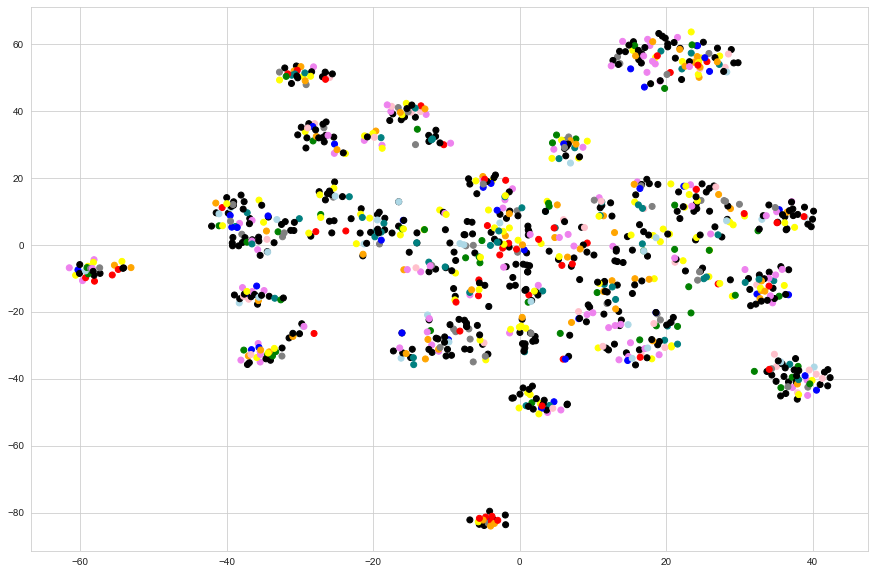

In [57]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

ax.scatter(model_X_d2[:,0],model_X_d2[:,1], c=colors)